# Table of Contents
1. [Setup](#Setup)
2. [Preprocessing](#Preprocessing)
3. [ML Pipeline](#ML-Pipeline)
    1. [Train-Test Split](#Train-Test-Split)
    2. [Random Forest](#Train-Random-Forest)
    3. [Deep Learning](#Train-Deep-Learning)
    4. [Ensemble Model](#Ensemble-Model)

# Setup
[Back to Top](#Table-of-Contents)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
from tqdm import *

In [2]:
# ROOT_DIR - root directory
ROOT_DIR = os.getcwd()+'/'

# FEATURE_DIR - directory where feature dataframes are saved
DATA_DIR = ROOT_DIR + 'dataframes/'

In [3]:
DF_prest = pd.read_csv(DATA_DIR+'DF_prest_filtered.csv',index_col=0)
print 'Number of prESTs:', len(DF_prest)
DF_prest.head()

Number of prESTs: 22603


,prest_id,uniprot_id,conc_cf,aa_seq,nt_seq,aa_len,true_nt_seq,AAA,AAT,AAC,...,ronn_avg,ronn_results,ronn_frac,disopred_results,disopred_avg,disopred_pb_results,disopred_pb_avg,disopred_frac,disopred_pb_frac,expressed
1,140099,G3V537,2.91540,TYYAWKHELLGSGTCPALPPREVLGMEELEKLPEEQVAEEELECSA...,GACAAGCTTGCGGCCGCAACCTACTATGCCTGGAAGCATGAGCTGC...,144,ACCTACTATGCCTGGAAGCATGAGCTGCTGGGCTCTGGCACCTGCC...,0.006944,0.013889,0.013889,...,0.488125,tyyawkhellGSGTcPALPPREVLGMEELEKLPEEQVAEEELECSa...,0.493056,tyyawkhellgsgtCPALPPREVLGMEELEKLPEEQVAEEELECSA...,0.421597,..............^^^^^^--^^^^^^^^^^^^^^^^^^^-^^^^...,0.352917,0.465278,0.423611,False
2,140225,P12724,1.48770,SLHARPPQFTRAQWFAIQHISLNPPRCTIAMRAINNYRWRCKNQNT...,GACAAGCTTGCGGCCGCATCACTCCATGCCAGACCCCCACAGTTTA...,136,TCACTCCATGCCAGACCCCCACAGTTTACGAGGGCTCAGTGGTTTG...,0.007353,0.051471,0.058824,...,0.368750,SLharppqftraqwfaiqhislnpprctiamrainnyrwrcknqnt...,0.058824,slharppqftraqwfaiqhislnpprctiamrainnyrwrcknqnt...,0.034338,.................................................,0.000000,0.000000,0.000000,False
5,140325,O43506,1.50290,FVGWWTHQRFVELVVVVDNIRYLFSQSNATTVQHEVFNVVNIVDSF...,GACAAGCTTGCGGCCGCATTTGTGGGCTGGTGGACCCATCAGCGGT...,137,TTTGTGGGCTGGTGGACCCATCAGCGGTTTGTTGAGCTGGTAGTGG...,0.014599,0.072993,0.021898,...,0.310584,fvgwwthqrfvelvvvvdnirylfsqsnattvqhevfnvvnivdsf...,0.000000,fvgwwthqrfvelvvvvdnirylfsqsnattvqhevfnvvnivdsf...,0.015912,.................................................,0.000000,0.000000,0.000000,False
8,140354,O95072,0.92003,RRRLLFWDKETQISPEKFQEQLQTRAHCWECPMVQPPERTIRGPAE...,GACAAGCTTGCGGCCGCACGTCGCCGGTTACTGTTCTGGGACAAGG...,134,CGTCGCCGGTTACTGTTCTGGGACAAGGAGACTCAGATCTCCCCGG...,0.014925,0.000000,0.000000,...,0.540448,rrrllfWDKETQISPEKFQEQLQTRAHCWEcPmvQPPERTIRGPae...,0.671642,Rrrllfwdketqispekfqeqlqtrahcwecpmvqppertirgpae...,0.271269,-................................................,0.191791,0.208955,0.201493,False
10,140500,C9J919,2.21830,MQQPPPQKVRINLQQQPPPLQIKSVPLPTLKMQTTLVPPTVESSPE...,GACAAGCTTGCGGCCGCAATGCAACAGCCTCCACCTCAGAAAGTTC...,140,ATGCAACAGCCTCCACCTCAGAAAGTTCGAATCAATTTACAGCAAC...,0.014286,0.021429,0.021429,...,0.587714,MQQPPPQKVRINLQQQPPPLQIKSVPLPTLKMQTTLVPPTVESSPE...,0.771429,MQQPPPQKVRINLQQQPpplQIKsvplPtLKMQTTLVPPTVESSPE...,0.489143,^^^^^^^^^^^^^^^^^...^^^....-.----^-------^^^^^...,0.453500,0.585714,0.471429,False


# Preprocessing
[Back to Top](#Table-of-Contents)

There are very few highly expressed proteins when there are >4 prESTs from the same uniprot, as these were peptides that were difficult to express

In [4]:
df_counts = pd.DataFrame(data=0,columns=['high','low'],index=set(DF_prest.groupby('uniprot_id').count().aa_seq))

for name, group in tqdm(DF_prest.groupby('uniprot_id')):
    n = len(group.conc_cf)
    df_counts.loc[n,'high'] += sum(group.expressed==True)
    df_counts.loc[n,'low'] += sum(group.expressed==False)

100%|██████████| 12851/12851 [00:12<00:00, 1065.91it/s]


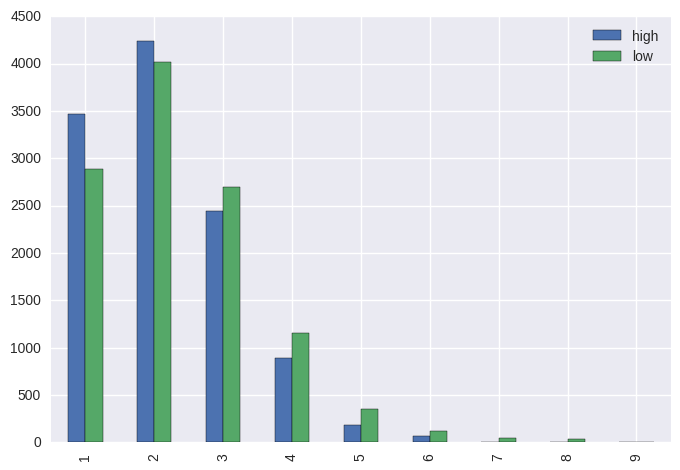

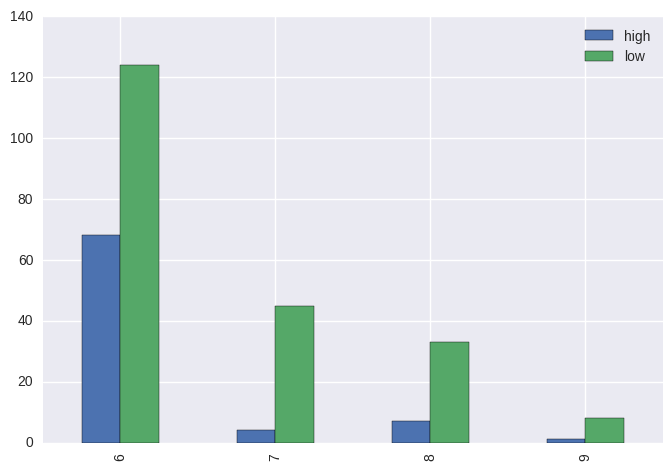

In [5]:
df_counts.plot(kind='bar')
df_counts[df_counts.index > 5].plot(kind='bar')

Only keep proteins that have <5 prESTs per protein

In [6]:
low_num_uniprots = DF_prest.groupby('uniprot_id').count().aa_seq[DF_prest.groupby('uniprot_id').count().aa_seq < 5].index.tolist()
DF_prest_filtered = DF_prest[DF_prest.uniprot_id.isin(low_num_uniprots)]

prest_id
1    6354
2    4122
3    1712
4     511
Name: aa_seq, dtype: int64


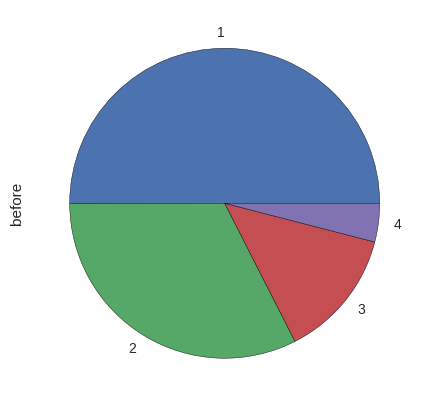

In [7]:
# Number of prESTs per protein
pie_var = DF_prest_filtered.groupby('uniprot_id').count().groupby('prest_id').count().aa_seq
pie = (pie_var).plot(kind='pie',fontsize=10,figsize=(5,5),label='before')
print(pie_var)

# ML Pipeline
[Back to Top](#Table-of-Contents)

This pipeline mirrors the classification workflow, except for splitting training and testing datasets

### Train-Test Split
[Back to Top](#Table-of-Contents)

In [8]:
# Get the number of prESTs per each uniprot
uniprot_counts = DF_prest_filtered.groupby('uniprot_id').count().prest_id

# Add all uniprots with a single prEST to the training set
training_uniprots = uniprot_counts[uniprot_counts == 1].index.tolist()

# Randomly pick 1/4 of other uniprots and add them to training set
random.seed(10)
other_uniprots = uniprot_counts[uniprot_counts > 1].index.tolist()
training_uniprots += random.sample(other_uniprots,len(other_uniprots)/4)

# Add all remaining uniprots to test set
testing_uniprots = list(set(uniprot_counts.index.tolist()) - set(training_uniprots))

In [9]:
print 'Total number of proteins:', len(DF_prest_filtered.uniprot_id.unique())
print 'Number of training proteins:', len(training_uniprots)
print 'Number of testing proteins:', len(testing_uniprots)

Total number of proteins: 12699
Number of training proteins: 7940
Number of testing proteins: 4759


In [10]:
# Add all prESTs in training uniprots to training set
DF_train = DF_prest_filtered[DF_prest_filtered.uniprot_id.isin(training_uniprots)]
DF_train.loc[:,'status'] = ['Train']*len(DF_train)
print 'Training set size:', len(DF_train)

# Repeat for test set
DF_test = DF_prest_filtered[DF_prest_filtered.uniprot_id.isin(testing_uniprots)]
DF_test.loc[:,'status'] = ['Test']*len(DF_test)
print 'Testing set size:', len(DF_test)

Training set size: 10245
Testing set size: 11533


/home/anand/.virtualenvs/tensorflow/local/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/anand/.virtualenvs/tensorflow/local/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# Create machine learning algorithm

In [11]:
DF_prest_final = pd.concat([DF_train,DF_test],axis=0)
print 'Size of final dataset:',len(DF_prest_final)

Size of final dataset: 21778


In [13]:
aa_features = ['list_comp_A','list_comp_R','list_comp_N',
               'list_comp_D','list_comp_C','list_comp_Q','list_comp_E','list_comp_G',
               'list_comp_H','list_comp_I','list_comp_L','list_comp_K','list_comp_M',
               'list_comp_F','list_comp_P','list_comp_S','list_comp_T','list_comp_W',
               'list_comp_Y','list_comp_V',
               # Amino acid types
               'frac_aliphatic', 'frac_uncharged_polar', 'frac_polar',
               'frac_hydrophobic', 'frac_positive', 'frac_sulfur', 'frac_negative', 'frac_amide',
               'frac_alcohol']

disorder_features = ['disembl_COILS_frac','disembl_REM465_frac','disembl_HOTLOOPS_frac','ronn_avg','ronn_frac',
                    'disopred_avg','disopred_pb_avg','disopred_frac','disopred_pb_frac']

                    
phys_features = ['aa_len',                                        
                # Physical properties
                 'bio_pI','bio_mW','bio_aromaticity','bio_instability','bio_gravy','abs_avg_charge','abs_charge',
                 'avg_charge']
                    
rna_features = ['AAA','AAC','AAT','AAG','ACA','ACC','ACT','ACG','ATA','ATC','ATT','ATG','AGA','AGC','AGT',
                'AGG','CAA','CAC','CAT','CAG','CCA','CCC','CCT','CCG','CTA','CTC','CTT','CTG','CGA','CGC',
                'CGT','CGG','TAA','TAC','TAT','TAG','TCA','TCC','TCT','TCG','TTA','TTC','TTT','TTG','TGA',
                'TGC','TGT','TGG','GAA','GAC','GAT','GAG','GCA','GCC','GCT','GCG','GTA','GTC','GTT','GTG',
                'GGA','GGC','GGT','GGG',
                'GC_content','list_nuc_A','list_nuc_C','list_nuc_G','list_nuc_T',
                'GC30',
                # SD sequences
                'sd_like_fwd','sd_like_fwd_frac','sd_like_rev','sd_like_rev_frac','sd_seq_fwd',
                'sd_seq_fwd_frac','sd_seq_rev','sd_seq_rev_frac',
                # RNA folding
                'RNA_folding_energy','RNA_40_energy','tAI']
                    
ss_features = ['acc20_mean','ss_helix', 'ss_ext', 'ss_c', 'ss8_helix', 'ss8_ext', 'ss8_turn', 'ss8_helix3',
               'ss8_pi_helix', 'ss8_bridge', 'ss8_bend', 'ss8_coil', 'acc_frac',
               'in_gravy','out_gravy', 'acc_hydrophilic_in','acc_hydrophilic_out',
               'acc_hydrophobic_in','acc_hydrophobic_out']

list_of_features = aa_features+disorder_features+phys_features+rna_features+ss_features + ['status']

DF_prest_features = DF_prest_final[list_of_features]

In [14]:
X = DF_prest_features.values
y = DF_prest_final['expressed'].values
n_samples, n_features = X.shape
print("No. of samples = %d" % n_samples)
print("No. of features = %d" % n_features)

No. of samples = 21778
No. of features = 148


In [15]:
X_train = X[X[:,-1]=='Train'][:,:-1]
X_test = X[X[:,-1]=='Test'][:,:-1]
y_train = y[X[:,-1]=='Train']
y_test = y[X[:,-1]=='Test']

from sklearn.preprocessing import StandardScaler
scl = StandardScaler().fit(X_train)
X_train = scl.transform(X_train)
X_test = scl.transform(X_test)

/home/anand/.virtualenvs/tensorflow/local/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


## Train Random Forest
[Back to Top](#Table-of-Contents)

In [16]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200,oob_score=True,random_state=0,n_jobs=-1)

params = {'n_estimators': [200,500,1000],
           'max_depth': [6,10,15,20,None],
           'min_samples_leaf': [1,2,5],
           'min_samples_split': [2,5]
        }

In [17]:
from sklearn.model_selection import GridSearchCV
clf.fit(X_train,y_train)
print 'Initial Training Accuracy:',clf.score(X_train,y_train)
print 'Initial Testing Accuracy:',clf.score(X_test,y_test)

n_subsamples = 1000
X_small_train, y_small_train = X_train[:n_subsamples], y_train[:n_subsamples]

gs = GridSearchCV(clf,
                  params,
                  cv=3,
                  verbose=1,
                  scoring = 'roc_auc',
                  error_score=0,
                  n_jobs=-1)

_ = gs.fit(X_small_train, y_small_train)
clf.set_params(**gs.best_params_)
clf.fit(X_train, y_train)

print 'Final Training Accuracy:',clf.score(X_train,y_train)
print 'Final Testing Accuracy:',clf.score(X_test,y_test)


Initial Training Accuracy: 1.0
Initial Testing Accuracy: 0.678487817567
Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  2.7min finished


Final Training Accuracy: 0.90326988775
Final Testing Accuracy: 0.678921356109


## Train Deep Learning

In [37]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
TF_DIR = ROOT_DIR+'misc_files/tf_models/'

In [38]:
train_set = tf.contrib.learn.python.learn.datasets.base.Dataset(data=X_train.astype(np.float32),target=y_train.astype(np.float32))
test_set = tf.contrib.learn.python.learn.datasets.base.Dataset(data=X_test.astype(np.float32),target=y_test.astype(np.float32))

In [39]:
# Specify important validation metrics
validation_metrics = {'accuracy': tf.contrib.metrics.streaming_accuracy,
                      'precision': tf.contrib.metrics.streaming_precision,
                      'recall': tf.contrib.metrics.streaming_recall}

# Specify that all features have real-value data
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=147)]

In [42]:
# Initialize model directory
model_dir = TF_DIR+'retrospective/'

# Initialize Monitor
monitor_params = {'x':test_set.data,
                 'y':test_set.target,
                 'every_n_steps':50,
                 'metrics':validation_metrics,
                 'early_stopping_metric':'loss',
                 'early_stopping_metric_minimize':True,
                 'early_stopping_rounds':200}

monitor = tf.contrib.learn.monitors.ValidationMonitor(**monitor_params)

clf_params = {'feature_columns':feature_columns,
              'hidden_units':[100,200,100],
              'n_classes':2,
              'activation_fn':tf.nn.relu,
              'optimizer':tf.train.RMSPropOptimizer(learning_rate=0.0001),
              'dropout':0.5,
              'config':tf.contrib.learn.RunConfig(save_checkpoints_secs=1),
              'model_dir': model_dir}

fit_params = {'x':train_set.data,
              'y':train_set.target,
              'steps':10000,
              'monitors':[monitor]}

In [70]:
# Initialize classifier
final_nn = tf.contrib.learn.DNNClassifier(**clf_params)

# Train classifier
# final_nn.fit(**fit_params)

# Test classifier
scores = final_nn.evaluate(x=test_set.data, y=test_set.target)
print('Accuracy: {0:f}'.format(scores['accuracy']))
print('AUC: {0:f}'.format(scores['auc']))

Accuracy: 0.676060
AUC: 0.752618


# Figures

### Visualize spread of prESTs across different proteins using original dataframe

In [44]:
DF_prest_final.head()

,prest_id,uniprot_id,conc_cf,aa_seq,nt_seq,aa_len,true_nt_seq,AAA,AAT,AAC,...,ronn_results,ronn_frac,disopred_results,disopred_avg,disopred_pb_results,disopred_pb_avg,disopred_frac,disopred_pb_frac,expressed,status
1,140099,G3V537,2.9154,TYYAWKHELLGSGTCPALPPREVLGMEELEKLPEEQVAEEELECSA...,GACAAGCTTGCGGCCGCAACCTACTATGCCTGGAAGCATGAGCTGC...,144,ACCTACTATGCCTGGAAGCATGAGCTGCTGGGCTCTGGCACCTGCC...,0.006944,0.013889,0.013889,...,tyyawkhellGSGTcPALPPREVLGMEELEKLPEEQVAEEELECSa...,0.493056,tyyawkhellgsgtCPALPPREVLGMEELEKLPEEQVAEEELECSA...,0.421597,..............^^^^^^--^^^^^^^^^^^^^^^^^^^-^^^^...,0.352917,0.465278,0.423611,False,Train
2,140225,P12724,1.4877,SLHARPPQFTRAQWFAIQHISLNPPRCTIAMRAINNYRWRCKNQNT...,GACAAGCTTGCGGCCGCATCACTCCATGCCAGACCCCCACAGTTTA...,136,TCACTCCATGCCAGACCCCCACAGTTTACGAGGGCTCAGTGGTTTG...,0.007353,0.051471,0.058824,...,SLharppqftraqwfaiqhislnpprctiamrainnyrwrcknqnt...,0.058824,slharppqftraqwfaiqhislnpprctiamrainnyrwrcknqnt...,0.034338,.................................................,0.000000,0.000000,0.000000,False,Train
10,140500,C9J919,2.2183,MQQPPPQKVRINLQQQPPPLQIKSVPLPTLKMQTTLVPPTVESSPE...,GACAAGCTTGCGGCCGCAATGCAACAGCCTCCACCTCAGAAAGTTC...,140,ATGCAACAGCCTCCACCTCAGAAAGTTCGAATCAATTTACAGCAAC...,0.014286,0.021429,0.021429,...,MQQPPPQKVRINLQQQPPPLQIKSVPLPTLKMQTTLVPPTVESSPE...,0.771429,MQQPPPQKVRINLQQQPpplQIKsvplPtLKMQTTLVPPTVESSPE...,0.489143,^^^^^^^^^^^^^^^^^...^^^....-.----^-------^^^^^...,0.453500,0.585714,0.471429,False,Train
11,140587,A0A0D9SFN7,1.1715,LSAVAATKSPIIFIGTGEHIDDFEPFKTQPFISKLLGMGDIEGLID...,GACAAGCTTGCGGCCGCACTCAGTGCAGTCGCTGCCACAAAAAGTC...,113,CTCAGTGCAGTCGCTGCCACAAAAAGTCCGATTATTTTCATTGGTA...,0.061947,0.026549,0.008850,...,lsavaatkspiifigtgehiddfepfktqpfiskllgmgdieglid...,0.070796,Lsavaatkspiifigtgehiddfepfktqpfiskllgmgdieglid...,0.163451,-................................................,0.095575,0.106195,0.097345,False,Train
14,140607,P08311,3.0094,NDIMLLQLSRRVRRNRNVNPVALPRAQEGLRPGTLCTVAGWGRVSM...,CAGAATGACATCATGTTATTGCAGCTGAGCAGAAGAGTCAGACGGA...,147,AATGACATCATGTTATTGCAGCTGAGCAGAAGAGTCAGACGGAATC...,0.006803,0.020408,0.020408,...,ndimllqlsrRVRRNRNVNPVALPRAQEGLRPGtlctvagwgrvsm...,0.210884,ndimllqlsrrvrrnrnvnpvalpraqeglrpgtlctvagwgrvsm...,0.061293,.................................................,0.032381,0.034014,0.034014,False,Train


In [45]:
# Create feature dataframe for test group
DF_retro = DF_prest_final[DF_prest_final.status == 'Test'][aa_features+disorder_features+phys_features+rna_features+ss_features+['aa_seq','prest_id','uniprot_id','expressed']]
DF_retro_features = DF_retro.drop(['aa_seq','prest_id','uniprot_id','expressed'],1)

In [46]:
pie_var = DF_retro.groupby('uniprot_id').count().groupby('prest_id').count().aa_seq
pie_var = pd.Series(np.array(pie_var),index=range(2,len(pie_var)+2))
print pie_var

2    3118
3    1267
4     374
dtype: int64


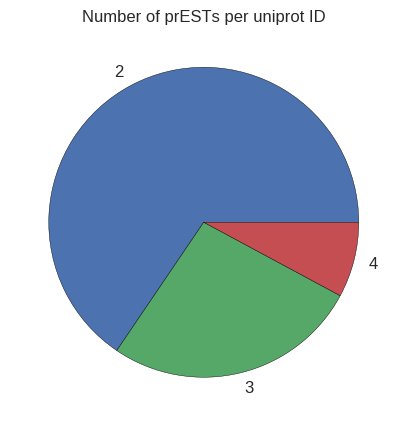

In [47]:
pie = (pie_var).plot(kind='pie',fontsize=12,figsize=(5,5))
pie.set_ylabel('')
pie.set_title('Number of prESTs per uniprot ID')
#plt.savefig(FIGURE_DIR+'pie_chart.svg',transparent=True,format='svg')

#### Get classifier score and true score

In [59]:
DF_retro.loc[:,'rf_score'] = clf.predict_proba(DF_retro_features)[:,1]
DF_retro.loc[:,'nn_score'] = final_nn.predict_proba(test_set.data)[:,1]
DF_retro.loc[:,'ens_score'] = DF_retro[['rf_score','nn_score']].mean(axis=1)

In [60]:
DF_retro_final = DF_retro[['prest_id','uniprot_id','expressed','rf_score','nn_score','aa_seq','ens_score']].sort_values('uniprot_id',ascending=0).reset_index(drop=True)
DF_retro_final.head()

,prest_id,uniprot_id,expressed,rf_score,nn_score,aa_seq,ens_score
0,3020371,X6RKY7,True,0.530606,0.692124,AEFRCFVKENKLIGISQRDYTQYYDHISKQKEEIRRCIQDFFKKHI...,0.611365
1,3020373,X6RKY7,True,0.480333,0.545103,KEHVLHCQFSAWYPFFRGVTIKSVILPLPQNVKDYLLDDGTLVVSG...,0.512718
2,2730004,X6RKQ2,False,0.414361,0.426968,TGGAFKGFKGLVVPSGGGRFSGFGSGAGGKPLEGLSNGNNITSAPP...,0.420664
3,2730001,X6RKQ2,True,0.477594,0.619637,EGDSGECKGGDEEENDEPPKVVVTEVKEEDAFYSKKCKLFYKKDNE...,0.548615
4,2730002,X6RKQ2,True,0.464907,0.429130,GSTKLQQESTFLFHGNKTEDTPDKKMEVASEKKTDPSSLGATSASF...,0.447019


### Original Data Statistics

In [71]:
print 'Original total number of experiments:',len(DF_retro_final)
print 'Original total number of proteins:',len(DF_retro_final.uniprot_id.unique())

Original total number of experiments: 11533
Original total number of proteins: 4759


In [72]:
print 'Original Number of passed experiments:',len(DF_retro_final[DF_retro_final.expressed])
print 'Original Pass rate: %.2f%%'%(np.true_divide(len(DF_retro_final[DF_retro_final.expressed]),len(DF_retro_final))*100)
print 'Number of proteins with >1 high expression:',len(DF_retro_final[DF_retro_final.expressed].uniprot_id.unique())

Original Number of passed experiments: 5680
Original Pass rate: 49.25%
Number of proteins with >1 high expression: 3572


In [86]:
print 'True positive:', len(DF_retro_final[(DF_retro_final.ens_score > .5) & (DF_retro_final.expressed)])

True positive: 4334


In [87]:
print 'False Positive:',len(DF_retro_final[(DF_retro_final.ens_score > .5) & (DF_retro_final.expressed==False)])

False Positive: 2295


In [88]:
print 'True Negative:',len(DF_retro_final[(DF_retro_final.ens_score < .5) & (DF_retro_final.expressed==False)])

True Negative: 3558


In [89]:
print 'False Negative:',len(DF_retro_final[(DF_retro_final.ens_score < .5) & (DF_retro_final.expressed)])

False Negative: 1346


### Grab only the top predicted prESTs for each protein

In [79]:
n = 5
np.random.seed(0)

output_df = pd.DataFrame(columns=['prest_id','uniprot_id','expressed','ens_score','aa_seq'])
remaining_df = DF_retro_final.copy()

for i in range(n):
    print 'Iteration',i
    new_output_df = remaining_df.sort_values(['uniprot_id','ens_score'],ascending=[1,0]).drop_duplicates('uniprot_id')
    output_df = pd.concat([output_df,new_output_df])
   
    pred_pos_proteins = set(output_df[output_df.ens_score > 0.5].uniprot_id)
    true_pos_proteins = set(output_df[output_df.expressed].uniprot_id)
    print 'Total number of proposed experiments:',len(output_df)
    print 'Total number of expressed proteins:',len(true_pos_proteins)
    print 'Overall pass rate:',np.true_divide(len(true_pos_proteins),len(output_df))

    # Prepare for next iteration
    remaining_df = remaining_df.drop(new_output_df.index)
    remaining_df = remaining_df[remaining_df.uniprot_id.isin(true_pos_proteins)==False]

    print
print 'Percent saved experiments:',(1 - np.true_divide(len(output_df),len(DF_retro_final)))*100,'%'


Iteration 0
Total number of proposed experiments: 4759
Total number of expressed proteins: 2947
Overall pass rate: 0.619247741122

Iteration 1
Total number of proposed experiments: 6571
Total number of expressed proteins: 3490
Overall pass rate: 0.531121594887

Iteration 2
Total number of proposed experiments: 6987
Total number of expressed proteins: 3565
Overall pass rate: 0.510233290396

Iteration 3
Total number of proposed experiments: 7069
Total number of expressed proteins: 3572
Overall pass rate: 0.505304852171

Iteration 4
Total number of proposed experiments: 7069
Total number of expressed proteins: 3572
Overall pass rate: 0.505304852171

Percent saved experiments: 38.7063209919 %
